# 加载环境

In [1]:
from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import GC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame

import keras
from keras.utils import np_utils
from keras.layers import Input, TimeDistributed, Flatten, Dense, Dropout
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF


Using TensorFlow backend.


# 超参数

In [2]:
SEED = 727
LENGTH = 512
EPOCHES = 100
BATCH_SIZE = 300
HIDDEN_UNITS = 1024

# 读入数据

In [3]:
file = r'deeploc_data.fasta'
records = list(SeqIO.parse(file, "fasta"))

In [4]:
print('Number of records: ' + str(len(records)))

Number of records: 14004


In [5]:
squences = []
description = []
for seq in records:
    if len(seq) < LENGTH:
        squences.append("".join(list(seq.seq) + (['0'] * (LENGTH - len(seq)))))
        description.append(seq.description)
    else:
        pass

In [6]:
description[0]

'Q9H400 Cell.membrane-M test'

# 格式整理

In [7]:
def toOneHot(base):
    if base == "C":
        base_one_hot = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "S":
        base_one_hot = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "T":
        base_one_hot = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "P":
        base_one_hot = [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "A":
        base_one_hot = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "G":
        base_one_hot = [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "N":
        base_one_hot = [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "D":
        base_one_hot = [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "E":
        base_one_hot = [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
    elif base == "Q":
        base_one_hot = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
    elif base == "H":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0]
    elif base == "R":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
    elif base == "K":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
    elif base == "M":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
    elif base == "I":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]
    elif base == "L":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]
    elif base == "V":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
    elif base == "F":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
    elif base == "Y":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
    elif base == "W":
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
    else:
        base_one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    return base_one_hot

In [8]:
squence_list = []
result_list = []
for seq in squences:
    seq_list = list(seq)
    for base in seq_list:
        squence_list.append(toOneHot(base))
    squence_array = np.array(squence_list)
    result_list.append(np.transpose(squence_array))
    squence_list = []
X = np.array(result_list)
del(squence_list, result_list, seq, seq_list, base, squence_array)

In [9]:
def toLocation(item):
    if item == "Cell.membrane":
        Location = 0
    elif item == "Cytoplasm-Nucleus":
        Location = 1
    elif item == "Cytoplasm":
        Location = 2
    elif item == "Endoplasmic.reticulum":
        Location = 3
    elif item == "Golgi.apparatus":
        Location = 4
    elif item == "Lysosome/Vacuole":
        Location = 5
    elif item == "Mitochondrion":
        Location = 6
    elif item == "Nucleus":
        Location = 7
    elif item == "Peroxisome":
        Location = 8
    elif item == "Plastid":
        Location = 9
    elif item == "Extracellular":
        Location = 10 
    return Location

In [10]:
location_list = []
result_list = []
for i in description:
    i_temp = i.split(" ")
    i_list = i_temp[1].split("-")
    location_list.append(i_list[0])
for item in location_list:
    result_list.append(toLocation(item))
Y = np.array(result_list)
Y = np.transpose(Y)
del(location_list, result_list, description, i, i_temp, i_list, item)

# 数据分割

In [11]:
np.random.seed(SEED)
msk = np.random.rand(len(Y)) < 0.8
X_train = X[msk]
Y_train = Y[msk]
X_test = X[~msk]
Y_test = Y[~msk]
print("number of data for train: " + str(len(X_train)))
print("number of data for test: " + str(len(X_test)))
print("number of label for train: " + str(len(Y_train)))
print("number of label for test: " + str(len(Y_test)))

number of data for train: 6951
number of data for test: 1702
number of label for train: 6951
number of label for test: 1702


# 格式整理

In [12]:
X_train4D=X_train.reshape(X_train.shape[0],LENGTH,20,1).astype('float32')
X_test4D=X_test.reshape(X_test.shape[0],LENGTH,20,1).astype('float32')

In [13]:
Y_train_One_Hot = np_utils.to_categorical(Y_train)
Y_test_One_Hot = np_utils.to_categorical(Y_test)

# 垃圾回收

In [14]:
del(X, Y, X_train, X_test, Y_train)

# 建立模型

In [15]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D

In [16]:
model = Sequential()

## 卷积层1 (20×LENGTH 16层)

In [17]:
model.add(Conv2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(LENGTH,20,1), 
                 activation='relu'))

## 池化层1 (20×½LENGTH 16层)

In [18]:
model.add(MaxPooling2D(pool_size=(2, 2)))

## 卷积层2 (10×½LENGTH 36层)

In [19]:
model.add(Conv2D(filters=36,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

## 池化层2 (10×¼LENGTH 36层)

In [20]:
model.add(MaxPooling2D(pool_size=(2, 2)))

In [21]:
model.add(Dropout(0.25))

## 平坦层 (5×¼LENGTH*36个神经元)

In [22]:
model.add(Flatten())

## 隐藏层 (HIDDEN_LAYER_NEURONS个神经元)

In [23]:
model.add(Dense(HIDDEN_UNITS, activation='relu'))

In [24]:
model.add(Dropout(0.5))

## 输出层 (11个神经元)

In [25]:
model.add(Dense(11,activation='softmax'))

In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 20, 16)       416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 10, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 10, 36)       14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 5, 36)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 5, 36)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              23593984  
__________

# 训练模型

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy']) 

In [28]:
train_history=model.fit(x=X_train4D, 
                        y=Y_train_One_Hot,validation_split=0.2, 
                        epochs=EPOCHES, batch_size=BATCH_SIZE,verbose=2)

Train on 5560 samples, validate on 1391 samples
Epoch 1/100
 - 13s - loss: 2.3943 - acc: 0.2094 - val_loss: 3.6953 - val_acc: 0.0000e+00
Epoch 2/100
 - 5s - loss: 1.8992 - acc: 0.3016 - val_loss: 5.0525 - val_acc: 0.0000e+00
Epoch 3/100
 - 5s - loss: 1.8245 - acc: 0.3144 - val_loss: 6.5438 - val_acc: 0.0000e+00
Epoch 4/100
 - 6s - loss: 1.7239 - acc: 0.3547 - val_loss: 7.6448 - val_acc: 0.0000e+00
Epoch 5/100
 - 5s - loss: 1.5314 - acc: 0.4475 - val_loss: 8.0405 - val_acc: 0.0093
Epoch 6/100
 - 5s - loss: 1.3831 - acc: 0.5112 - val_loss: 8.7063 - val_acc: 0.0208
Epoch 7/100
 - 5s - loss: 1.3161 - acc: 0.5297 - val_loss: 8.2467 - val_acc: 0.0216
Epoch 8/100
 - 5s - loss: 1.2382 - acc: 0.5685 - val_loss: 9.6277 - val_acc: 0.0280
Epoch 9/100
 - 5s - loss: 1.1886 - acc: 0.5696 - val_loss: 9.3297 - val_acc: 0.0266
Epoch 10/100
 - 6s - loss: 1.1507 - acc: 0.5872 - val_loss: 8.9497 - val_acc: 0.0302
Epoch 11/100
 - 5s - loss: 1.0625 - acc: 0.6241 - val_loss: 9.2792 - val_acc: 0.0324
Epoch 12/

Epoch 96/100
 - 6s - loss: 0.0140 - acc: 0.9957 - val_loss: 15.3658 - val_acc: 0.0302
Epoch 97/100
 - 6s - loss: 0.0170 - acc: 0.9948 - val_loss: 15.3995 - val_acc: 0.0345
Epoch 98/100
 - 6s - loss: 0.0149 - acc: 0.9948 - val_loss: 15.3906 - val_acc: 0.0295
Epoch 99/100
 - 5s - loss: 0.0155 - acc: 0.9953 - val_loss: 15.3618 - val_acc: 0.0295
Epoch 100/100
 - 5s - loss: 0.0152 - acc: 0.9959 - val_loss: 15.3105 - val_acc: 0.0288


In [29]:
def show_train_history_acc(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.ylim((0, 1))
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
def show_train_history_loss(train_loss,test_loss):
    plt.plot(train_history.history[train_loss])
    plt.plot(train_history.history[test_loss])
    plt.ylim((0, 1))         
    plt.title('Train History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

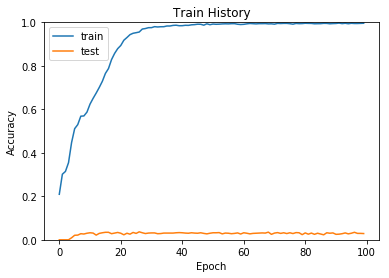

In [30]:
show_train_history_acc('acc','val_acc')

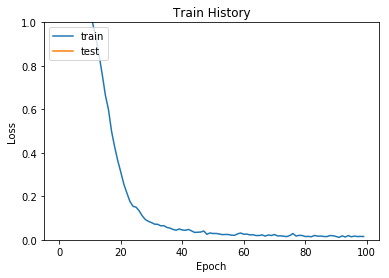

In [31]:
show_train_history_loss('loss','val_loss')

# 评估模型的准确率

In [32]:
scores = model.evaluate(X_test4D , Y_test_One_Hot)
scores[1]

1702/1702 [==============================] - 1s 416us/step


0.4688601645123384

In [33]:
prediction=model.predict_classes(X_test4D)

In [34]:
import pandas as pd
pd.crosstab(Y_test,prediction,
            rownames=['label'],colnames=['predict'])

predict,0,2,3,4,5,6,7,8,9
label,,,,,,,,,
0,62,11,18,4,1,6,14,1,1
2,6,113,8,0,2,27,100,0,6
3,11,14,53,5,1,15,10,0,1
4,5,7,10,13,1,8,8,0,0
5,7,4,7,0,17,3,5,0,1
6,8,15,3,1,3,132,32,0,7
7,7,75,8,2,1,19,321,0,4
8,0,3,1,0,0,5,2,6,0
9,1,3,7,0,0,15,7,0,81


In [35]:
predicted_Probaility = model.predict(X_test4D)

In [36]:
pd.DataFrame(predicted_Probaility[0:50])

,0,1,2,3,4,5,6,7,8,9,10
0,9.522923e-01,1.729355e-12,4.063926e-02,3.614966e-03,1.163469e-07,2.333709e-06,3.383917e-03,1.658769e-06,6.540822e-05,4.904625e-13,2.817727e-12
1,2.555369e-01,4.597945e-14,6.765380e-02,4.488581e-04,2.585679e-06,7.953745e-07,1.771956e-14,6.763570e-01,9.169423e-08,3.143363e-15,4.026733e-14
2,2.059366e-03,1.164788e-12,4.810603e-09,2.769398e-01,1.142609e-02,8.475042e-02,6.248034e-01,7.015559e-09,2.082619e-05,6.274515e-11,4.255685e-14
3,1.641216e-02,4.748395e-13,9.813222e-01,8.357644e-07,1.635309e-09,1.873908e-08,2.933135e-05,7.707117e-06,2.227696e-03,3.967128e-14,9.738189e-13
4,9.443793e-07,3.438866e-11,1.403520e-07,5.506021e-05,4.291496e-09,6.566794e-07,9.999217e-01,1.055482e-05,8.870683e-09,1.079518e-05,5.644332e-11
5,9.603039e-01,4.888372e-08,1.740224e-02,9.149914e-04,4.292359e-04,1.109999e-04,1.454597e-02,7.129063e-04,6.362987e-06,5.573289e-03,3.197964e-08
6,3.284077e-05,1.211065e-11,1.009653e-04,7.733522e-01,2.589391e-06,7.004016e-08,2.254975e-01,1.013762e-03,5.199951e-08,5.265736e-11,1.193325e-10
7,9.999927e-01,6.589760e-16,3.571516e-10,6.694998e-06,2.283005e-09,6.482776e-07,3.047280e-10,1.872020e-12,4.241429e-09,6.487720e-12,9.115498e-16
8,9.281783e-01,1.880003e-11,2.683942e-04,6.710319e-02,4.284230e-03,1.517101e-04,5.564203e-09,4.059624e-08,1.420400e-05,6.357962e-09,1.850599e-11
9,9.999999e-01,6.625597e-17,3.314398e-08,5.241685e-11,4.044710e-10,7.710247e-09,1.205901e-12,1.072326e-07,1.349727e-10,3.791953e-16,3.887640e-17


In [37]:
Y_test[0]

0